In [1]:
import torch
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn import tree
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import math
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot

from pathlib import Path
import requests
import pickle
import gzip

import torch
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
device=get_default_device()

In [4]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [5]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [6]:
pd.options.display.float_format="{:,.4f}".format

In [7]:
class DealDataset(Dataset):
    """
        读取数据、初始化数据
    """
    def __init__(self, folder, data_name, label_name,transform=None):
        with gzip.open(os.path.join(folder,label_name), 'rb') as lbpath: # rb表示的是读取二进制数据
            y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

        with gzip.open(os.path.join(folder,data_name), 'rb') as imgpath:
            x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
        self.train_set = x_train.reshape(x_train.shape[0],-1)
        self.train_labels = y_train
        self.train_set
        self.train_labels
        self.transform = transform

    def __getitem__(self, index):

        img, target = self.train_set[index], int(self.train_labels[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.train_set)

In [8]:
# 实例化这个类，然后我们就得到了Dataset类型的数据，记下来就将这个类传给DataLoader，就可以了。
trainDataset = DealDataset('dataset/mnist_dataset', "train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz",transform=transforms.ToTensor())
testDataset = DealDataset('dataset/mnist_dataset', "t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz",transform=transforms.ToTensor())

print(trainDataset.train_set.shape)
print(trainDataset.train_labels.shape)
print(testDataset.train_set.shape)
print(testDataset.train_labels.shape)

train_loader = DataLoader(
    dataset=trainDataset,
    batch_size=100, # 一个批次可以认为是一个包，每个包中含有100张图片
    shuffle=False,
)

test_loader = DataLoader(
    dataset=testDataset,
    batch_size=100,
    shuffle=False,
)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [9]:
print(len(trainDataset))
print(len(testDataset))

60000
10000


In [10]:
def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"])
    #DataFrame 数据帧，输入数据Y_data,列为一列，且标签为labels
    y_data["i"]=np.arange(len(y_data))
    #创建等差数列，相当于再加一列
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i]
        #选择该类的行
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        #对该类的所有数据进行随机打乱
        label_info=label_info[0:amount]
        #根据参数选择前amount个
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        #重新更新label_info
        label_dict.update({var_name: label_info })
        #讲该类选择的数据加入字典中
    return label_dict

In [11]:
def get_iid_subsamples_indices(label_dict, number_of_samples, amount):
    #旨在为每个节点划分iid数据
    #number_of_samples:节点个数
    #amount 总量；
    #batch_size 每个节点应该拥有的数据量
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples))
    for i in range(number_of_samples):
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        for j in range(10):
            label_name=str("label")+str(j)
            a=label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb=pd.concat([dumb,a], axis=0)
            #每一类数据进行拼接
        dumb.reset_index(drop=True, inplace=True)
        #单机样本重排序
        sample_dict.update({sample_name: dumb}) 
    return sample_dict

In [12]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    #主要目的，对每个节点进行随即后索引分配，分配完之后进行实际数据集分割，每一个节点的实际数据构成一个节点数据集；
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)):  
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        #遍历每个节点中的数据
        indices=np.sort(np.array(sample_dict[sample_name]["i"]))
        #print(indices)
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_info
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict

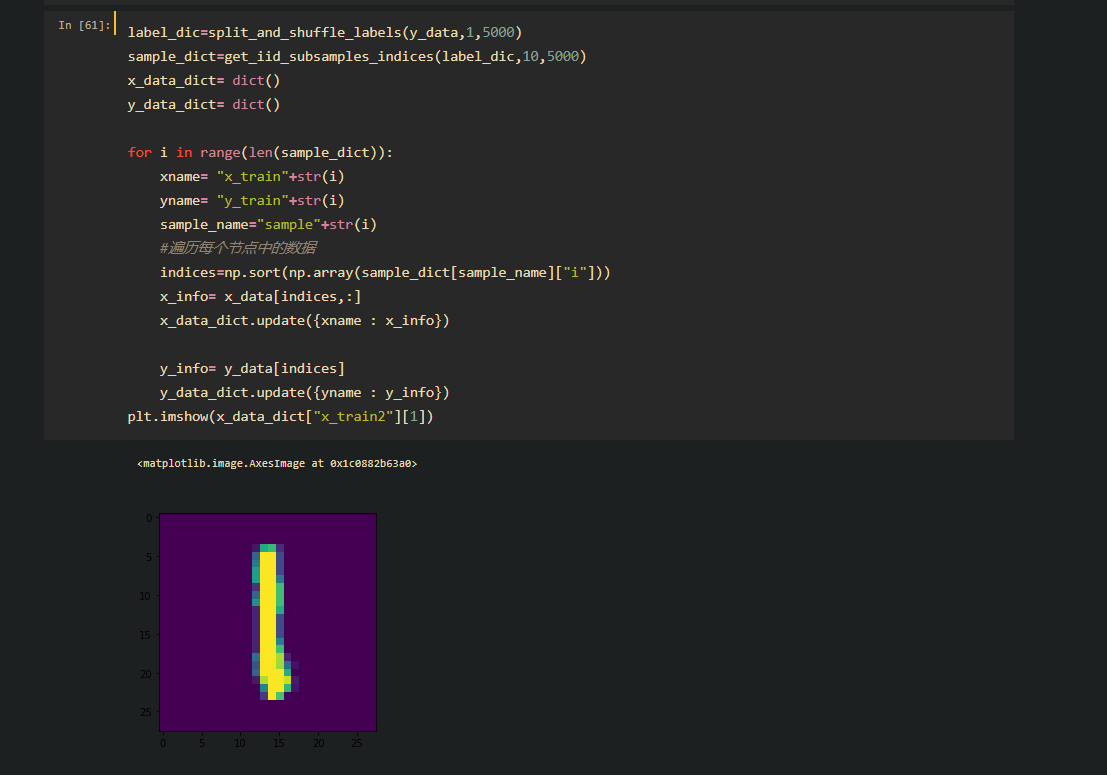

In [13]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn,self).__init__()
        self.fc1=nn.Linear(784,200)
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,10)
    
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [14]:
class WrappedDataLoader:
    def __init__(self,dl,func):
        self.dl=dl
        self.func=func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches=iter(self.dl)
        for b in batches:
            yield(self.func(*b))

In [15]:
def train(model,train_loader,criterion,optimizer):
    #训练部分
    model.train()
    train_loss=0.0
    correct=0
    
    for data,target in train_loader:
        optimizer.zero_grad()
        output=model(data.float())
        loss=criterion(output,target.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        #print(loss.item())
    return train_loss / len(train_loader), correct/len(train_loader.dataset)     

In [16]:
def validation(model, test_loader, criterion):
    #验证部分
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.float())
            
            test_loss += criterion(output, target.long()).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

In [17]:
def create_model_optimizer_criterion_dict(number_of_samples):
    #为每个节点创建基本模型，整体保存为model_dict、optimizer_dict、criterion_dict以节点名为键
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.Adam(model_info.parameters(), lr=0.001)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict

In [18]:
def get_averaged_weights(model_dict, number_of_samples):
    #服务器节点平均函数，直接对模型各个层参数进行整体平均
    fc1_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc1.weight.shape)
    fc1_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc1.bias.shape)
    
    fc2_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc2.weight.shape)
    fc2_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc2.bias.shape)
    
    fc3_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc3.weight.shape)
    fc3_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc3.bias.shape)
    
    with torch.no_grad():
    
    
        for i in range(number_of_samples):
            fc1_mean_weight += model_dict[name_of_models[i]].fc1.weight.data.clone()
            fc1_mean_bias += model_dict[name_of_models[i]].fc1.bias.data.clone()
        
            fc2_mean_weight += model_dict[name_of_models[i]].fc2.weight.data.clone()
            fc2_mean_bias += model_dict[name_of_models[i]].fc2.bias.data.clone()
        
            fc3_mean_weight += model_dict[name_of_models[i]].fc3.weight.data.clone()
            fc3_mean_bias += model_dict[name_of_models[i]].fc3.bias.data.clone()

        
        fc1_mean_weight =fc1_mean_weight/number_of_samples
        fc1_mean_bias = fc1_mean_bias/ number_of_samples
    
        fc2_mean_weight =fc2_mean_weight/number_of_samples
        fc2_mean_bias = fc2_mean_bias/ number_of_samples
    
        fc3_mean_weight =fc3_mean_weight/number_of_samples
        fc3_mean_bias = fc3_mean_bias/ number_of_samples
    
    return fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias

In [19]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples):
    #云服务器模型更新为平均后的模型
    fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.fc1.weight.data = fc1_mean_weight.data.clone()
        main_model.fc2.weight.data = fc2_mean_weight.data.clone()
        main_model.fc3.weight.data = fc3_mean_weight.data.clone()

        main_model.fc1.bias.data = fc1_mean_bias.data.clone()
        main_model.fc2.bias.data = fc2_mean_bias.data.clone()
        main_model.fc3.bias.data = fc3_mean_bias.data.clone() 
    return main_model

In [20]:
def compare_local_and_merged_model_performance(number_of_samples):
    accuracy_table=pd.DataFrame(data=np.zeros((number_of_samples,3)), columns=["sample", "local_ind_model", "merged_main_model"])
    for i in range (number_of_samples):
    
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        #test_ds相当于把零散的数据标签/图片数据集拼接为整个数据集，整体tensor为二维矩阵[图片，标签]；
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
        #使用dataloader进行加载，进行数据分批，每次为batch_size个数据；
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        individual_loss, individual_accuracy = validation(model, test_dl, criterion)
        main_loss, main_accuracy =validation(main_model, test_dl, main_criterion )
    
        accuracy_table.loc[i, "sample"]="sample "+str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table

In [21]:
def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    #对各个节点局部模型进行平均
    with torch.no_grad():
        for i in range(number_of_samples):

            model_dict[name_of_models[i]].fc1.weight.data =main_model.fc1.weight.data.clone()
            model_dict[name_of_models[i]].fc2.weight.data =main_model.fc2.weight.data.clone()
            model_dict[name_of_models[i]].fc3.weight.data =main_model.fc3.weight.data.clone() 
            
            model_dict[name_of_models[i]].fc1.bias.data =main_model.fc1.bias.data.clone()
            model_dict[name_of_models[i]].fc2.bias.data =main_model.fc2.bias.data.clone()
            model_dict[name_of_models[i]].fc3.bias.data =main_model.fc3.bias.data.clone() 
    
    return model_dict

In [22]:
def start_train_end_node_process(number_of_samples):
    #针对于每个节点，进行模型本地epch个轮次训练
    for i in range (number_of_samples): 
        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

#         valid_ds = TensorDataset(x_valid_dict[name_of_x_valid_sets[i]], y_valid_dict[name_of_y_valid_sets[i]])
#         valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)
        
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        print("Subset" ,i)
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
#             valid_loss, valid_accuracy = validation(model, valid_dl, criterion)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
    
            print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [23]:
def start_train_end_node_process_without_print(number_of_samples):
    #没有输出日志的本地节点训练
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        #print(next(model.parameters()).device)
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)

In [24]:
def start_train_end_node_process_print_some(number_of_samples, print_amount):
    #仍然是本地节点训练，进行部分信息输出；
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        if i<print_amount:
            print("Subset" ,i)
            
        for epoch in range(numEpoch):
        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
            
            if i<print_amount:        
                print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [25]:
x_train=torch.tensor(trainDataset.train_set)
y_train=torch.tensor(trainDataset.train_labels)
x_test=torch.tensor(testDataset.train_set)
y_test=torch.tensor(testDataset.train_labels)
#x_train=DeviceDataLoader(x_train,device)
#y_train=DeviceDataLoader(y_train,device)
#x_test=DeviceDataLoader(x_test,device)
#y_test=DeviceDataLoader(y_test,device)

#_train, y_train,x_test, y_test = map(torch.tensor, (x_train, y_train, x_test, y_test))
#Python map针对于第二参数列表，调用参数一函数
number_of_samples=100
learning_rate = 0.01
numEpoch = 20
batch_size = 32
momentum = 0.9

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

<ipython-input-25-b0261fe0b0ed>:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  x_train=torch.tensor(trainDataset.train_set)


In [ ]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.Adam(centralized_model.parameters(), lr=0.001)
centralized_criterion = nn.CrossEntropyLoss()

In [33]:
#进行训练集分批和合并
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [ ]:
print("------ 单模型、全数据集单节点训练 ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) +" | train loss: {:7.4f}".format(central_train_loss)+ " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

In [26]:
#根据之前定义的样本分割函数，进行各个节点的数据样本分割，分割形式为iid形式
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")

label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=1, amount=test_amount) 
sample_dict_test = get_iid_subsamples_indices(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount)
x_test_dict, y_test_dict = create_iid_subsamples(sample_dict=sample_dict_test, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")

In [27]:
#主要模型
main_model = Net2nn()
main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001)
main_criterion = nn.CrossEntropyLoss()

In [28]:
#对100个节点进行初始化，构造相应的优化器模型等；
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_samples)

In [29]:
#获得所有集合名字
name_of_x_train_sets=list(x_train_dict.keys())
name_of_y_train_sets=list(y_train_dict.keys())
name_of_x_test_sets=list(x_test_dict.keys())
name_of_y_test_sets=list(y_test_dict.keys())

name_of_models=list(model_dict.keys())
name_of_optimizers=list(optimizer_dict.keys())
name_of_criterions=list(criterion_dict.keys())

In [30]:
model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, numEpoch)

In [31]:
start_train_end_node_process(number_of_samples)

Subset 0
epoch:   1 | train accuracy: 0.44667 | test accuracy: 0.66667
epoch:   2 | train accuracy: 0.81111 | test accuracy: 0.73333
epoch:   3 | train accuracy: 0.90667 | test accuracy: 0.78889
epoch:   4 | train accuracy: 0.95556 | test accuracy: 0.85556
epoch:   5 | train accuracy: 0.96889 | test accuracy: 0.82222
epoch:   6 | train accuracy: 0.99111 | test accuracy: 0.88889
epoch:   7 | train accuracy: 0.99778 | test accuracy: 0.86667
epoch:   8 | train accuracy: 1.00000 | test accuracy: 0.88889
epoch:   9 | train accuracy: 1.00000 | test accuracy: 0.86667
epoch:  10 | train accuracy: 1.00000 | test accuracy: 0.87778
epoch:  11 | train accuracy: 1.00000 | test accuracy: 0.87778
epoch:  12 | train accuracy: 1.00000 | test accuracy: 0.87778
epoch:  13 | train accuracy: 1.00000 | test accuracy: 0.87778
epoch:  14 | train accuracy: 1.00000 | test accuracy: 0.87778
epoch:  15 | train accuracy: 1.00000 | test accuracy: 0.87778
epoch:  16 | train accuracy: 1.00000 | test accuracy: 0.87778

epoch:  15 | train accuracy: 1.00000 | test accuracy: 0.83333
epoch:  16 | train accuracy: 1.00000 | test accuracy: 0.83333
epoch:  17 | train accuracy: 1.00000 | test accuracy: 0.83333
epoch:  18 | train accuracy: 1.00000 | test accuracy: 0.83333
epoch:  19 | train accuracy: 1.00000 | test accuracy: 0.83333
epoch:  20 | train accuracy: 1.00000 | test accuracy: 0.83333
Subset 7
epoch:   1 | train accuracy: 0.50444 | test accuracy: 0.81111
epoch:   2 | train accuracy: 0.85333 | test accuracy: 0.88889
epoch:   3 | train accuracy: 0.94667 | test accuracy: 0.86667
epoch:   4 | train accuracy: 0.98667 | test accuracy: 0.84444
epoch:   5 | train accuracy: 0.98889 | test accuracy: 0.87778
epoch:   6 | train accuracy: 1.00000 | test accuracy: 0.82222


KeyboardInterrupt: 

In [34]:
for i in range(5):
    model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)
    start_train_end_node_process_without_print(number_of_samples)
    main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 
    test_loss, test_accuracy = validation(main_model, test_dl, main_criterion)
    print("Iteration", str(i+2), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))

Iteration 2 : main_model accuracy on all test data:  0.9126
Iteration 3 : main_model accuracy on all test data:  0.9281
Iteration 4 : main_model accuracy on all test data:  0.9363
Iteration 5 : main_model accuracy on all test data:  0.9410
Iteration 6 : main_model accuracy on all test data:  0.9442
